In [1]:
import pandas as pd
# from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import sklearn

In [2]:
# 数据集载入
data = pd.read_csv("dataset.csv")
data

,肝素浓度,肝素IU浓度,ATP,ATPS酶加入量,3-ost加入量,反应时间,相对于t0的效价提升率,相对于初始投入的效价提升率
0,20.00,1500.00,390.0,18.0,40.000000,54.0,0.2211,0.0000
1,10.00,750.00,1300.0,60.0,133.333333,66.0,-0.0104,-0.0120
2,0.33,23.33,78.0,3.6,8.000000,48.0,-0.0157,0.0500
3,10.00,750.00,1950.0,30.0,66.666667,53.0,-0.0246,0.0328
4,0.33,23.33,78.0,3.6,8.000000,0.0,0.0000,0.0667
...,...,...,...,...,...,...,...,...
93,20.00,1500.00,390.0,18.0,40.000000,72.0,0.1775,0.0000
94,10.00,750.00,650.0,30.0,66.666667,24.0,-0.0987,-0.0456
95,10.00,750.00,650.0,30.0,66.666667,72.0,-0.0987,-0.0456
96,0.33,23.33,78.0,3.6,8.000000,54.0,0.0522,0.1224


In [3]:
# 分离feature与Label，先只拿相对t0的效价提升率
data_feature = data.iloc[:, 0:6]
data_label_t0 = data.iloc[:, 6]
data_label_t0

0     0.2211
1    -0.0104
2    -0.0157
3    -0.0246
4     0.0000
       ...  
93    0.1775
94   -0.0987
95   -0.0987
96    0.0522
97    0.0303
Name: 相对于t0的效价提升率, Length: 98, dtype: float64

In [5]:
# 读取测试集
datatest = pd.read_csv("datatest.csv")
datatest

,肝素浓度,肝素IU浓度,ATP,ATPS酶加入量,3-ost加入量,反应时间
0,10.00,750.00,5200.0,240.0,533.333333,72
1,20.00,1500.00,156.0,3.6,8.000000,66
2,10.00,750.00,62.5,3.6,8.000000,48
3,30.00,2250.00,390.0,18.0,40.000000,99
4,10.00,750.00,156.0,1.8,4.000000,0
5,10.00,750.00,78.0,3.6,8.000000,64
6,10.00,750.00,650.0,30.0,66.666667,0
7,0.33,23.33,78.0,3.6,8.000000,30
8,10.00,750.00,70.2,3.6,8.000000,54
9,10.00,750.00,156.0,3.6,8.000000,48


In [6]:
# 划分验证集与训练集， 使用随机森林回归分类器
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

### 使用均方根误差(RMSE)评价指标，结果显示相对来说比较少  均方根误差越小越好

### 再使用R^2决定系数进行评估  

In [7]:
regressor = RandomForestRegressor(n_estimators=100,random_state=0)
score = cross_val_score(regressor, data_feature, data_label_t0, cv=10
               ,scoring = "neg_mean_squared_error").mean()
# sorted(sklearn.metrics.SCORERS.keys())#sklearn当中的模型评估指标（打分）列表
score = np.sqrt(abs(score))
score

0.09405710696252335

### 对r2指标来说如果结果是0，就说明模型预测不能预测因变量。 如果结果是1。就说明是函数关系。 如果结果是0-1之间的数，就是我们模型的好坏程度。

In [11]:
score_r2 = cross_val_score(regressor, data_feature, data_label_t0, cv=10
               ,scoring = "r2").mean()
score_r2  # ?????怎么会是呢？

0.05943326793809885

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:56<00:00,  4.73s/it]

0.09297503175403891
160


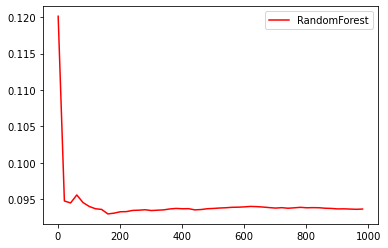

In [21]:
# 画出学习曲线 n_estimators = 168暂定
from tqdm import tqdm

learnList = []
for i in tqdm(range(1, 1000, 20)):
    regressor = RandomForestRegressor(n_estimators= i ,random_state=0)
    score = cross_val_score(regressor, data_feature, data_label_t0, cv=10
               ,scoring = "neg_mean_squared_error").mean()
    score = np.sqrt(abs(score))
    learnList.append(score)
#     print(i)

print(min(learnList))
print(20 * learnList.index(min(learnList)))
plt.plot(range(1, 1000, 20), learnList, color='r', label='RandomForest')
plt.legend()
plt.show()

### 定位到n_estimators = 168, 接下来使用网格搜索，对全局进行参数搜索

In [56]:
# 网格搜索，寻找最优参数
gini_threholds = np.linspace(0,0.5,50)

#参数的取值范围
parameters = {
#                 "criterion":("gini", "entropy")
#               "n_estimators":[*range(100, 1000, 10)]
#               ,"splitter":("best","random")
              "max_depth":[*range(1,11)]
              ,"min_samples_leaf":[*range(1,50,5)]
#               ,"min_impurity_decrease":np.linspace(0,0.5,50)
             }

regressor = RandomForestRegressor(random_state=450)

gs = GridSearchCV(regressor, parameters,cv=10)
gs.fit(data_feature, data_label_t0)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=450),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                              46]})

In [57]:
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 1}

In [58]:
gs.best_score_

0.08940825934501742

### 确定随机森林回归算法最优参数为：n_estimators = 168; max_depth = 3; min_samples_leaf = 1

In [10]:
# 输出预测结果
regressor = RandomForestRegressor(n_estimators=168 ,random_state=480, max_depth=3, min_samples_leaf=1)

regressor = regressor.fit(data_feature, data_label_t0,)
score = regressor.score(data_feature, data_label_t0,)
prediction = regressor.predict(datatest)
# score
prediction

array([ 0.11256438,  0.12703523,  0.0651003 ,  0.14973409,  0.00658303,
        0.17494707, -0.00157409,  0.02169354,  0.17793365,  0.07472438])

In [66]:
newResult = pd.DataFrame(prediction)
newResult = pd.concat([datatest, newResult], axis=1)
newResult.to_csv("newResultTest.csv", encoding='utf_8_sig')

### 算法测试  XGBOOST （未调参数的结果比未调参数的随机森林差）

In [18]:
# xgboost
import xgboost as xgb

xgbresult = xgb.XGBRegressor()
xgbresult.fit(data_feature, data_label_t0)
xgb_pred = xgbresult.predict(datatest)
# xgb_pred

score_xgb = cross_val_score(xgbresult, data_feature, data_label_t0, cv=10
               ,scoring = "neg_mean_squared_error").mean()
score_xgb_r2 = cross_val_score(xgbresult, data_feature, data_label_t0, cv=10
               ,scoring = "r2").mean()
# sorted(sklearn.metrics.SCORERS.keys())#sklearn当中的模型评估指标（打分）列表
score_xgb = np.sqrt(abs(score_xgb))

print("score:", score_xgb, "R2:", score_xgb_r2)
print("预测结果:", xgb_pred)

score: 0.09935639037910798 R2: -0.13471215776778936
预测结果: [ 0.15014139  0.13174586  0.01873773  0.12552118 -0.0016045   0.3166389
 -0.04261411  0.07117822  0.23019086  0.09013344]


### 算法测试 SVM （未调参数的结果比未调参数的随机森林差）

In [19]:
# SVM
from sklearn import svm

svmResult = svm.SVR()
svmResult.fit(data_feature, data_label_t0)
svm_pred = svmResult.predict(datatest)

score_svm = cross_val_score(svmResult, data_feature, data_label_t0, cv=10
               ,scoring = "neg_mean_squared_error").mean()
score_svm_r2 = cross_val_score(svmResult, data_feature, data_label_t0, cv=10
               ,scoring = "r2").mean() 

score_svm = np.sqrt(abs(score_svm))

print("score:", score_svm, "R2:", score_svm_r2)
print("预测结果:", svm_pred)

score: 0.09956898357686761 R2: -0.0865267382938221
预测结果: [0.10253613 0.11786536 0.11385996 0.11831442 0.09125081 0.11668893
 0.02360117 0.02471835 0.1147429  0.10416687]


### 算法测试 深度前馈网络

In [ ]:
# 待测试

### 模型融合 （加权表决融合)

In [21]:
# 效果不是很好，放弃这个尝试
final_pred = 3/6 * prediction + 2/6 * xgb_pred + 1/6 * svm_pred
final_pred

array([ 0.12341867,  0.12707713,  0.05777272,  0.13642651,  0.01796515,
        0.21246799, -0.01105822,  0.03869257,  0.18482093,  0.08476782])